In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(T):
    p = T[0]; q = T[1]; r = T[2]; s = T[3]; t = T[4]; u = T[5]
    S = 0
    if p+q != 0:
        S += ((p-q)**2)/(p+q)
    if r+s != 0:
        S += ((r-s)**2)/(r+s)
    if t+u != 0:
        S += ((t-u)**2)/(t+u)
    return S

In [3]:
def DOLS_chi2(x,n,m):
    TG = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            
    #Step 1
    MCP = np.zeros((m,6)); MCN = np.zeros((m,6)) #MaxChange
    for i in range(m):
        T = TG[i]
        X = chi2(T); MCP[i] = np.zeros(6); MCN[i] = np.zeros(6)
        if T[0] >= 1:
            Y = chi2([T[0]-1, T[1], T[2]+1, T[3], T[4], T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
            Y = chi2([T[0]-1, T[1], T[2], T[3], T[4]+1, T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
        if T[1] >= 1:
            Y = chi2([T[0], T[1]-1, T[2], T[3]+1, T[4], T[5]])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
            Y = chi2([T[0], T[1]-1, T[2], T[3], T[4], T[5]+1])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
        if T[2] >= 1:
            Y = chi2([T[0]+1, T[1], T[2]-1, T[3], T[4], T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
            Y = chi2([T[0], T[1], T[2]-1, T[3], T[4]+1, T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
        if T[3] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3]-1, T[4], T[5]])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]-1, T[4], T[5]+1])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
        if T[4] >= 1:
            Y = chi2([T[0]+1, T[1], T[2], T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
            Y = chi2([T[0], T[1], T[2]+1, T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
        if T[5] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3], T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]+1, T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
    
    #Step 2
    LSS = np.zeros(int(2**m))
    for j in range(n):
        LSJ = np.zeros((m,int(2**m)))
        LSJ[0][0] = MCP[0][int(x[j][0])]; LSJ[0][1] = MCN[0][int(x[j][0])]
        #print(LSJ[0],LSJ[1])
        for i in range(1,m):
            for k in range(2**i):
                LSJ[i][2*k+0] = LSJ[i-1][k] + MCP[i][int(x[j][i])]
                LSJ[i][2*k+1] = LSJ[i-1][k] + MCN[i][int(x[j][i])]
        #print(LSJ)
        for i in range(int(2**m)):
            LSS[i] = max(LSS[i],LSJ[m-1][i])    
        #print(LSS)
        
    #Step 3
    DOLSP = np.zeros(m) #LS^{i+}
    DOLSN = np.zeros(m) #LS^{i-}
    
    for j in range(m):
        for i in range(int(2**m)):
            if int(i/(2**(m-1-j)))%2 == 0:
                DOLSP[j] = max(DOLSP[j], LSS[i])
            else:
                DOLSN[j] = max(DOLSN[j], LSS[i])
    
    return DOLSP, DOLSN

In [4]:
def h3(z,l):
    return (3*np.sqrt(3)*(l**(2/3)))/(4*math.pi*(math.fabs(z)**3+l))

def cdf(x,h,l):
    g = lambda z: h(z,l)
    return integrate.quad(g,-oo,x)

def noise(h,l,d): # using inverse transform sampling
    r = np.random.rand()
    q = 1000; z = 10
    for i in range(-50,50):
        if math.fabs(r - cdf(i/5,h,l)[0]) > q:
            z = (i-1)/5
            break
        else:
            q = min(q, math.fabs(r - cdf(i/5,h,l)[0]))
    if d == 0:
        return math.fabs(z)
    elif d == 1:
        return -math.fabs(z)
    
def alpha(k,l,m,ei): #epsilon = ei*m
    return ((l**(1/k))*(ei*m))/(2*((k-1)**((k-1)/k)))

In [5]:
def DOSS_chi2_test_positive(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            else:
                x[i+int(n/2)][j] = 3
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

def DOSS_chi2_test_negative(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            elif i < int((n-2)/4):
                x[i][j] = 2
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            elif i < int((n+2)/4):
                x[i+int(n/2)][j] = 3
            else:
                x[i+int(n/2)][j] = 5
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

In [6]:
def accuracy_positive(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,0)
                    acc[i][0] += math.fabs((DOLSP[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

def accuracy_negative(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,1)
                    acc[i][0] += math.fabs((DOLSN[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

[[0.30230978 0.59655797]
 [0.19591435 0.38660432]
 [0.15673148 0.30928345]
 [0.09612277 0.18968227]
 [0.04968614 0.09804732]
 [0.09190364 0.18135652]
 [0.04940662 0.09749572]
 [0.06735932 0.13292238]]
[[0.33606282 0.66316396]
 [0.2179272  0.430043  ]
 [0.09245396 0.18244249]
 [0.13207709 0.26063212]
 [0.04465464 0.08811848]
 [0.05503212 0.10859672]
 [0.04157982 0.08205085]
 [0.03389979 0.06689558]]
[[0.26415418 0.52126425]
 [0.12217131 0.24108471]
 [0.1074227  0.21198079]
 [0.08805139 0.17375475]
 [0.06289385 0.12411054]
 [0.08144754 0.16072314]
 [0.09685653 0.19113022]
 [0.09289422 0.18331126]]
[[0.19811563 0.39094819]
 [0.11226553 0.22153731]
 [0.17786381 0.35098459]
 [0.1203369  0.23746482]
 [0.11258    0.22215786]
 [0.03522056 0.0695019 ]
 [0.07239781 0.14286502]
 [0.07132163 0.14074135]]
[[0.23773876 0.46913782]
 [0.166197   0.32796209]
 [0.05899443 0.11641568]
 [0.10786296 0.21284957]
 [0.09371184 0.1849247 ]
 [0.0726424  0.14334767]
 [0.08658387 0.17085884]
 [0.05239058 0.103384

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


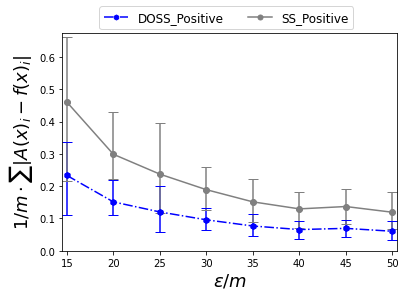

In [7]:
n = 150; m = 2

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_positive(n,m)

jj = 10
for j in range(jj):
    acc = accuracy_positive(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Positive")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Positive")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_positive_m=2.png")
fig.savefig("figs/Accuracy_chi2_positive_m=2.eps", bbox_inches="tight", pad_inches=0.05)

[[0.05610791 0.11221581]
 [0.02948528 0.05897055]
 [0.02404625 0.04809249]
 [0.02213781 0.04427563]
 [0.02257403 0.04514805]
 [0.01517204 0.03034407]
 [0.0176848  0.03536961]
 [0.0174049  0.0348098 ]]
[[0.08473439 0.16946878]
 [0.02633636 0.05267273]
 [0.03458079 0.06916158]
 [0.02137444 0.04274888]
 [0.02551846 0.05103693]
 [0.02748142 0.05496285]
 [0.01526746 0.03053491]
 [0.02152711 0.04305423]]
[[0.05763465 0.1152693 ]
 [0.04179466 0.08358933]
 [0.0270234  0.0540468 ]
 [0.02557299 0.05114598]
 [0.01603083 0.03206166]
 [0.02175613 0.04351225]
 [0.01374071 0.02748142]
 [0.02427526 0.04855051]]
[[0.02900817 0.05801634]
 [0.03721443 0.07442885]
 [0.0327487  0.06549739]
 [0.03549684 0.07099368]
 [0.0251913  0.05038261]
 [0.01331131 0.02662263]
 [0.02671805 0.0534361 ]
 [0.01213763 0.02427526]]
[[0.06412332 0.12824664]
 [0.04494358 0.08988716]
 [0.03068759 0.06137518]
 [0.02938986 0.05877971]
 [0.02453699 0.04907397]
 [0.01646023 0.03292046]
 [0.01743035 0.03486069]
 [0.01305368 0.026107

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.02557299 0.05114598]
 [0.05439032 0.10878063]
 [0.03687091 0.07374182]
 [0.02900817 0.05801634]
 [0.02977154 0.05954308]
 [0.02304432 0.04608864]
 [0.01895709 0.03791419]
 [0.0135117  0.0270234 ]]
[[0.05022993 0.10045987]
 [0.03609799 0.07219599]
 [0.0309624  0.06192481]
 [0.02820663 0.05641326]
 [0.0211836  0.04236719]
 [0.0197809  0.0395618 ]
 [0.01735401 0.03470802]
 [0.01693543 0.03387085]]


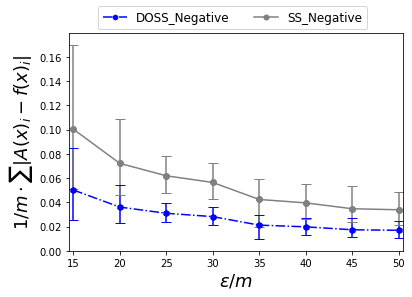

In [8]:
n = 150; m = 2

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_negative(n,m)

jj = 10
for j in range(jj):
    acc = accuracy_negative(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Negative")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Negative")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_negative_m=2.png")
fig.savefig("figs/Accuracy_chi2_negative_m=2.eps", bbox_inches="tight", pad_inches=0.05)